## CRUD opérations 

### 1: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

In [13]:
import pandas as pd
import py2neo

# Charger les données des statistiques des personnages
stats = pd.read_csv("C:/Users/oumis/Downloads/characters_stats.csv")

# Trier les personnages par vitesse de manière décroissante
fastest_characters = stats.sort_values(by='Speed', ascending=False).head(10)

# Connexion à la base de données Neo4j
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

# Liste pour stocker les personnages liés
related_characters = []

# Parcourir les 10 personnages les plus rapides
for character in fastest_characters['Name']:
    # Requête pour récupérer les personnages liés au personnage actuel
    query = f"MATCH (a:Superhero {{name:'{character}'}})-[:RELATION]-(b:Superhero) RETURN b.name"
    result = graph.run(query).data()
    # Ajouter les noms des personnages liés à la liste
    related_characters.extend([record['b.name'] for record in result])

# Supprimer les doublons des personnages liés
related_characters = list(set(related_characters))

# Afficher les 10 personnages les plus rapides et leurs relations
print("Les 10 personnages les plus rapides dans le MCU sont :")
print(fastest_characters['Name'].tolist())
print("Ils sont liés aux personnages suivants dans le graphe de la base de données Neo4j :")
print(related_characters)


Les 10 personnages les plus rapides dans le MCU sont :
['Zoom', 'Nova', 'Quicksilver', 'Bizarro', 'Krypto', 'Amazo', 'Stardust', 'Superboy-Prime', 'Jack of Hearts', 'Air-Walker']
Ils sont liés aux personnages suivants dans le graphe de la base de données Neo4j :
[]


### 2: How many have collaborated atleast more than 10 times with another superhero?

In [14]:
import py2neo

# Connexion à la base de données Neo4j
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

# Requête Cypher pour compter le nombre de superhéros ayant collaboré au moins 10 fois
query = """
MATCH (a:Superhero)-[r:RELATION]->(b:Superhero)
WHERE r.n_collab >= 10
RETURN COUNT(DISTINCT a) AS num_superheroes
"""

# Exécuter la requête et récupérer le résultat
result = graph.run(query).data()

# Afficher le nombre de superhéros ayant collaboré au moins 10 fois avec un autre superhéros
print("Nombre de superhéros ayant collaboré au moins 10 fois avec un autre superhéros :", result[0]['num_superheroes'])


Nombre de superhéros ayant collaboré au moins 10 fois avec un autre superhéros : 0


### 3: Did the weakest of the MCU collaborated with the strongest ?

In [15]:
# Requête Cypher pour trouver le superhéros le plus faible
query_weakest = """
MATCH (a:Superhero)
RETURN a.name AS weakest_superhero, a.Total AS weakest_strength
ORDER BY a.Total ASC
LIMIT 1
"""

# Exécuter la requête pour trouver le superhéros le plus faible
result_weakest = graph.run(query_weakest).data()

# Requête Cypher pour trouver le superhéros le plus fort
query_strongest = """
MATCH (b:Superhero)
RETURN b.name AS strongest_superhero, b.Total AS strongest_strength
ORDER BY b.Total DESC
LIMIT 1
"""

# Exécuter la requête pour trouver le superhéros le plus fort
result_strongest = graph.run(query_strongest).data()

# Vérifier s'il existe une relation de collaboration entre le plus faible et le plus fort
query_collaboration = """
MATCH (a:Superhero {name: $weakest_name})-[r:RELATION]->(b:Superhero {name: $strongest_name})
RETURN COUNT(r) AS num_collaborations
"""

# Exécuter la requête pour vérifier la collaboration
result_collaboration = graph.run(query_collaboration, weakest_name=result_weakest[0]['weakest_superhero'], strongest_name=result_strongest[0]['strongest_superhero']).data()

# Afficher le résultat
if result_collaboration[0]['num_collaborations'] > 0:
    print("Le superhéros le plus faible a collaboré avec le plus fort.")
else:
    print("Le superhéros le plus faible n'a pas collaboré avec le plus fort.")


Le superhéros le plus faible n'a pas collaboré avec le plus fort.


### 4: Give a stats that interests you !

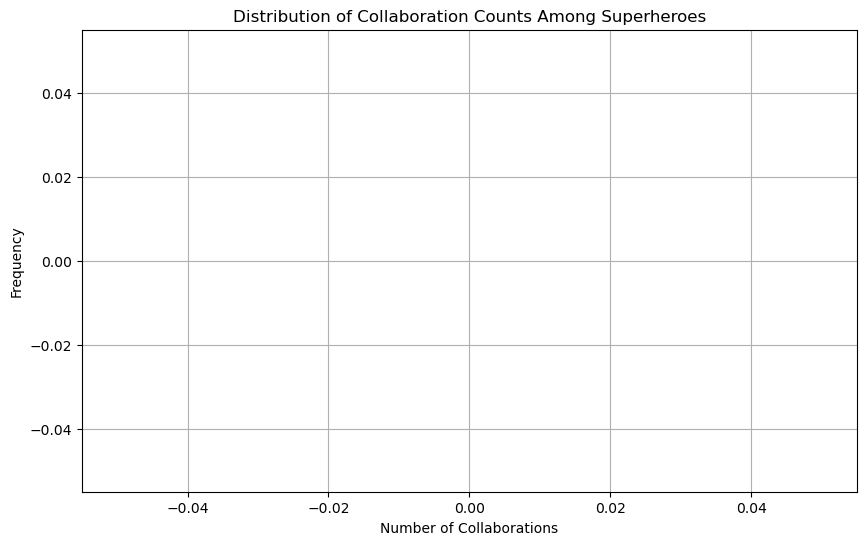

In [16]:
import matplotlib.pyplot as plt

# Cypher query to retrieve collaboration counts
query = """
MATCH (a:Superhero)-[r:RELATION]->(b:Superhero)
RETURN COUNT(r) AS collaboration_count
"""

# Execute the query
result = graph.run(query).data()

# Extract collaboration counts from the result
collaboration_counts = [record['collaboration_count'] for record in result]

# Plotting the distribution of collaboration counts
plt.figure(figsize=(10, 6))
plt.hist(collaboration_counts, bins=range(min(collaboration_counts), max(collaboration_counts) + 1, 1), color='skyblue', edgecolor='black')
plt.xlabel('Number of Collaborations')
plt.ylabel('Frequency')
plt.title('Distribution of Collaboration Counts Among Superheroes')
plt.grid(True)
plt.show()


### 5: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

In [17]:
import tqdm
import py2neo
import numpy as np

# Connect to the Neo4j database
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

# Supprimer toutes les données existantes dans la base de données "master"
graph.delete_all()

# Définition des noms des personnes dans le groupe M1
names = {
    "0": "Person1",
    "1": "Person2",
    "2": "Person3"
}

# Exécuter une requête pour créer une contrainte sur l'id_ de la personne pour garantir qu'il est unique (clé primaire)
try:
    graph.run("CREATE CONSTRAINT ON (:Person) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

# Initialiser une liste de transactions pour les commettre en même temps
transaction_list = []

# Générer des données aléatoires pour les personnes du groupe M1
for i in tqdm.tqdm(range(100)):
    id_ = i
    name = names[str(np.random.random(3).argmax())]
    age = int(np.random.randint(low=20, high=31, size=1)[0])  # Générer un âge entre 20 et 30 inclus
    # Ajouter un dictionnaire à la liste de transactions
    transaction_list.append({"id_": id_, "name": name, "age": age})
    if i % 3 == 2:  # Créer des groupes de 3 collaborateurs
        # Créer les noeuds pour chaque personne du groupe avec les informations fournies
        transaction = "UNWIND $json as data CREATE (n:Person) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

# Créer des relations non dirigées entre les membres du groupe
for i in range(0, 100, 3):
    # Créer des relations non dirigées entre les membres de chaque groupe de 3
    query = """
    MATCH (a:Person),(b:Person)
    WHERE a.id_ IN [{}, {}, {}] AND b.id_ IN [{}, {}, {}] AND a.id_ <> b.id_
    CREATE (a)-[:COLLAB]->(b)
    """.format(i, i + 1, i + 2, i, i + 1, i + 2)
    graph.run(query)


Constraint already exists


100%|██████████| 100/100 [00:00<00:00, 428.33it/s]


### 6: Get the age for people YOU collaborate with

In [18]:
# Votre nom pour la requête
votre_nom = "Person1"

# Requête Cypher
query = (
    "MATCH (p1:Person)-[:COLLAB]-(p2:Person) "
    f"WHERE p1.name = '{votre_nom}' "
    "RETURN p2.name AS Nom, p2.age AS Age"
)

# Exécuter la requête
result = graph.run(query)

# Afficher les résultats
for record in result:
    print(record["Nom"], record["Age"])


Person2 26
Person3 24
Person2 26
Person3 24
Person2 26
Person2 26
Person2 26
Person2 26
Person1 21
Person2 27
Person1 21
Person2 27
Person1 24
Person2 27
Person1 24
Person2 27
Person1 25
Person1 22
Person1 22
Person1 25
Person1 30
Person1 22
Person1 30
Person1 22
Person1 30
Person1 25
Person1 30
Person1 25
Person2 29
Person3 21
Person2 29
Person3 21
Person1 20
Person2 26
Person2 26
Person1 20
Person1 22
Person1 22
Person2 26
Person2 26
Person1 30
Person1 30
Person1 30
Person1 30
Person1 30
Person1 30
Person1 24
Person1 24
Person1 30
Person1 24
Person1 30
Person1 24
Person1 29
Person1 21
Person1 29
Person1 21
Person1 29
Person1 29
Person1 25
Person1 25
Person1 21
Person1 25
Person1 21
Person1 25
Person1 20
Person2 20
Person1 20
Person2 20
Person2 20
Person1 28
Person2 20
Person1 28
Person2 20
Person3 24
Person2 20
Person3 24
Person3 21
Person3 27
Person3 21
Person3 27
Person1 20
Person3 28
Person1 20
Person3 28
Person1 28
Person3 28
Person3 28
Person1 28
Person2 27
Person2 27
Person2 29

### 7: Get nodes with age > 25.

In [19]:
# Requête Cypher
query = (
    "MATCH (p:Person) "
    "WHERE p.age > 25 "
    "RETURN p.name AS Nom, p.age AS Age"
)

# Exécuter la requête
result = graph.run(query)

# Afficher les résultats
for record in result:
    print(record["Nom"], record["Age"])


Person1 27
Person2 26
Person2 26
Person2 26
Person1 28
Person2 27
Person1 30
Person3 30
Person2 29
Person2 26
Person2 29
Person3 30
Person1 30
Person1 30
Person1 29
Person1 28
Person1 28
Person3 27
Person3 28
Person1 28
Person2 27
Person1 27
Person2 29
Person3 30
Person1 30
Person3 26
Person2 29
Person1 29
Person1 26
Person3 26
Person3 27
Person3 29
Person2 30
Person2 30
Person3 29
Person2 30
Person3 28
Person3 29
Person3 28
Person1 26
Person3 30


## Real world problem:

### 8: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

In [24]:
pip install neo4j


     ---------------------------------------- 0.0/203.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/203.0 kB ? eta -:--:--
     ----- ------------------------------- 30.7/203.0 kB 325.1 kB/s eta 0:00:01
     ----------- ------------------------- 61.4/203.0 kB 465.5 kB/s eta 0:00:01
     ------------------------------------ - 194.6/203.0 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 203.0/203.0 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for neo4j: filename=neo4j-5.20.0-py3-none-any.whl size=280801 sha256=099bcd80b0f0

In [25]:
import py2neo
from neo4j import GraphDatabase

# Chemin vers le fichier texte
file_path = "C:/Users/oumis/Desktop/Nosql/arxiv_cs.txt"

# Fonction pour lire et importer les données depuis le fichier texte
def import_data(tx, file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            # Supprimer les caractères spéciaux et découper la ligne en listes
            data = line.strip().split("\t")
            # Créer un nœud pour chaque ligne avec le premier élément comme label
            tx.run("CREATE (node:" + data[0] + " {name: $name})", name=data[1])

# URL et informations d'authentification pour la base de données Neo4j
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password_tuts"

# Connexion à la base de données Neo4j
try:
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        # Création de la base de données Neo4j et importation des données
        session.write_transaction(import_data, file_path)
    print("Database created and data imported successfully.")
except Exception as e:
    print("An error occurred:", e)
finally:
    # Fermeture de la connexion au driver Neo4j
    if driver is not None:
        driver.close()


C:\Users\oumis\AppData\Local\Temp\ipykernel_46780\361468841.py:26: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(import_data, file_path)


An error occurred: list index out of range


## Real World application 3

### 1. Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

In [29]:
import json
from collections import defaultdict
from py2neo import Graph, Node, Relationship

# Load the JSON file
with open("C:/Users/oumis/Downloads/pubmed_cleaned/pubmed_cleaned.json", "r") as file:
    data = json.load(file)

# Preprocessing step: Extract author information and clean data
author_info = defaultdict(list)
for publication in data:
    if "authors" in publication:
        authors = publication["authors"]
        if isinstance(authors, list):  # Check if authors is a list
            for author in authors:
                name = author.get("name", "").strip().lower()
                affiliations = author.get("affiliations", [])
                author_info[name].extend(affiliations)

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

# Create nodes for authors
for author, affiliations in author_info.items():
    author_node = Node("Author", name=author, affiliations=affiliations)
    graph.create(author_node)

# Create edges between authors who co-authored the same paper
for publication in data:
    if "authors" in publication:
        authors = publication["authors"]
        if isinstance(authors, list):  # Check if authors is a list
            author_names = [author.get("name", "").strip().lower() for author in authors]
            for i in range(len(author_names)):
                for j in range(i + 1, len(author_names)):
                    author1 = author_names[i]
                    author2 = author_names[j]
                    graph.run("""
                        MATCH (a1:Author {name: $author1})
                        MATCH (a2:Author {name: $author2})
                        MERGE (a1)-[:CO_AUTHOR]->(a2)
                    """, author1=author1, author2=author2)


### 2. How many authors have more than 2 affiliations ?

In [30]:
from py2neo import Graph

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

# Define the Cypher query
query = """
MATCH (a:Author)
WHERE size(a.affiliations) > 2
RETURN count(a) AS numAuthorsWithMoreThanTwoAffiliations
"""

# Execute the query
result = graph.run(query)

# Extract the result
num_authors = result.evaluate()

print("Number of authors with more than two affiliations:", num_authors)


Number of authors with more than two affiliations: 0


### 3. Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

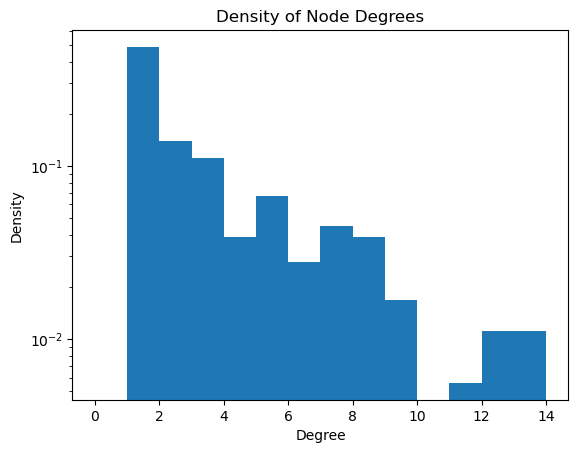

In [32]:
from py2neo import Graph
import matplotlib.pyplot as plt
import numpy as np

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

# Query to calculate the degree of each node
query = """
MATCH (n)
RETURN size((n)--()) AS degree
"""

# Execute the query
results = graph.run(query)

# Store degrees in a list
degrees = [record["degree"] for record in results]

# Plot the histogram of node degrees
plt.hist(degrees, bins=range(max(degrees)+1), density=True, log=True)
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Density of Node Degrees')
plt.show()


### 4. Which country has seen the most international collaboration ?

In [34]:
from py2neo import Graph

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"))

# Query to find international collaborations
query = """
MATCH (a:Author)-[:AUTHORED]->(:Publication)<-[:AUTHORED]-(b:Author)
WHERE a.country <> b.country
RETURN a.country AS country1, b.country AS country2, count(*) AS collaborations
"""

# Execute the query
results = graph.run(query)

# Find the country pair with the most collaborations
max_collaborations = 0
max_country_pair = None
for record in results:
    collaborations = record["collaborations"]
    country_pair = (record["country1"], record["country2"])
    if collaborations > max_collaborations:
        max_collaborations = collaborations
        max_country_pair = country_pair

# Check if there are international collaborations
if max_country_pair is not None:
    print("Country pair with the most international collaborations:")
    print("Country 1:", max_country_pair[0])
    print("Country 2:", max_country_pair[1])
    print("Number of collaborations:", max_collaborations)
else:
    print("There are no international collaborations in the database.")


There are no international collaborations in the database.
